## Dataset generation for GAN to learn NAKAGAMI channels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from keras.layers import Dense
from keras.models import Sequential,Model


from tensorflow.keras.optimizers import Adam

ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.9 from "C:\Users\R3KI3G\anaconda3\python.exe"
  * The NumPy version is: "1.20.3"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: DLL load failed while importing _multiarray_umath: The specified module could not be found.


In [2]:
# class GaussianNoise(tf.keras.layers.Layer):
#     def __init__(self, stddev, **kwargs):
#         super(GaussianNoise, self).__init__(**kwargs)
#         self.stddev = stddev

#     def call(self, inputs, training=None):
#         if 1 or training:
#             noise = tf.random.normal(tf.shape(inputs), stddev=self.stddev)
#             return inputs + noise
#         return inputs

#     def get_config(self):
#         config = super(GaussianNoise, self).get_config()
#         config.update({'stddev': self.stddev})
#         return config


class L2Normalization(tf.keras.layers.Layer):
    def __init__(self,**kwargs):

        super(L2Normalization, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.nn.l2_normalize(inputs, axis=-1)

    def get_config(self):
        return super(L2Normalization, self).get_config()

#     def get_config(self):
#         base_config = super().get_config()
#         config = {
#             "sublayer": keras.saving.serialize_keras_object(self.sublayer),
#         }
#         return {**base_config, **config}

#     @classmethod
#     def from_config(cls, config):
#         sublayer_config = config.pop("sublayer")
#         sublayer = keras.saving.deserialize_keras_object(sublayer_config)
#         return cls(sublayer, **config)






# def generate_nakagami_samples(m, omega, shape):

#     return tf.random.gamma(shape, m, 1/omega) ** 0.5

# class NakagamiNoiseLayer(tf.keras.layers.Layer):
#     def __init__(self, distribution_params, **kwargs):
#         super(NakagamiNoiseLayer, self).__init__(**kwargs)
#         self.distribution_params = distribution_params

#     def call(self, inputs, training=None):
#         if  1 or training:
#             # noise = tf.random.normal(tf.shape(inputs), **self.distribution_params)
#             if tf.shape(inputs)[0] == None:
#                 noise = generate_nakagami_samples(m = self.distribution_params["m"],
#                                               omega = self.distribution_params["omega"],
#                                               shape = tf.shape(inputs))
#             else:
#                 noise = generate_nakagami_samples(m = self.distribution_params["m"],
#                                               omega = self.distribution_params["omega"],
#                                               shape = tf.shape(inputs)[1:])
#             return inputs * noise

#         else:
#             return inputs







In [3]:
def calc_block_accuracy(preds,y_val):
    n_bits_per_block = preds.shape[1]
    n_correct_bits = np.sum(preds == y_val,axis=1)
    block_accuracy = np.mean(n_correct_bits == n_bits_per_block)
    return block_accuracy


In [4]:
def only_awgn(snr_db, num_samples):
    noise_var = 10**(-snr_db/10)
    noise_real = np.random.normal(scale=np.sqrt(noise_var), size=num_samples)
    noise_imag = np.random.normal(scale=np.sqrt(noise_var), size=num_samples)

    channel = noise_real + 1j * noise_imag

    return channel

In [5]:
def nakagami_channel(m, omega, snr_db, num_samples):
    """
    This function generates samples from a Nakagami-m fading channel.

    Args:
      m: Shape parameter of the Nakagami distribution (float).
      omega: Scale parameter of the Nakagami distribution (float).
      num_samples: Number of samples to generate (int).

    Returns:
      channel: Complex-valued channel coefficients (numpy.ndarray).
    """



    # Generate random variables from chi-squared distribution with 2*m degrees of freedom
    chi_squared = 2 * m * np.random.chisquare(2 * m, size=num_samples)

    # Generate real and imaginary parts from independent normal distributions
    real_part = np.sqrt(chi_squared / (2 * omega)) * np.random.normal(scale=1, size=num_samples)
    imag_part = np.sqrt(chi_squared / (2 * omega)) * np.random.normal(scale=1, size=num_samples)

    # affect of noise
    # r3ki3g added : noise
    noise_var = 10**(-snr_db/10) / (2 * m)
    noise_real = np.random.normal(scale=np.sqrt(noise_var), size=num_samples)
    noise_imag = np.random.normal(scale=np.sqrt(noise_var), size=num_samples)
    real_part += noise_real
    imag_part += noise_imag

    # Combine real and imaginary parts into complex channel coefficients
    channel = real_part + 1j * imag_part

    return channel


<font color="red">
    Number of blocks : scaked up
</font>

In [6]:
# generating the data set
k = 2
M = 2**k

NUM_CHANNEL_USES = 2


block_size = 320
n_blocks = 1000

n_train = block_size * n_blocks
n_val   = block_size * n_blocks

x_train = np.array(np.random.rand(n_train,k)<0.5).astype(np.float32)
# make first 16 as pilots
# [ 0 0 0 0] --> [1 1 1 1]
pilots_m = []
for i in range(M):
    pilots_m.append([
          ( (i//(2**j))%2 if j!=0 else i%2 ) for j in range(k-1,-1,-1)

    ])
pilots_m = np.array(pilots_m)
# replace the first 2**k symbols with pilots in each "320" block
for i in range(n_train//block_size):
    x_train[i*block_size:block_size*i+2**k,:] = pilots_m


# autoencoder training
y_train = x_train

# do the same for the validation
x_val = x_train
y_val = y_train






In [7]:
x_train.shape

(320000, 2)

In [8]:
pilots_m

array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]])

In [10]:
# complete_results = []

# nakagami_m = 7
# gamma_bar = 25
# AWGN_std = np.sqrt(OMEGA * 10 ** (-0.1 * gamma_bar) )

print(f"-------  start ----------")

AE = Sequential([


                Dense(2*k, activation='tanh',input_shape=(k,)),
                Dense(2*k, activation='tanh'),

                Dense(2*NUM_CHANNEL_USES, activation='linear'),
                L2Normalization(name="normalization_layer"),


#                 NakagamiNoiseLayer({"omega":OMEGA,"m":nakagami_m}),
#                 GaussianNoise(stddev=AWGN_std,name="channel"),

#                 L2Normalization(name="normalization_layer_at_rx"),

               # Dense(3*k, activation='tanh'),

                Dense(2*k, activation='tanh',name="decoder_start"),
                Dense(k, activation='sigmoid')



                ])




AE.compile(optimizer=Adam(learning_rate=1e-2),loss="binary_crossentropy")
AE.fit(x_train,y_train,epochs=10,verbose=1)
AE.compile(optimizer=Adam(learning_rate=1e-3),loss="binary_crossentropy")
AE.fit(x_train,y_train,epochs=10,verbose=1)



preds = AE.predict(x_val)>0.5
#         accuracy = np.mean( preds == y_val  )
accuracy =  calc_block_accuracy(preds,y_val)
print(f"validation accuracy = {accuracy}")








-------  start ----------
Epoch 1/10
10000/10000 [==============================] - 33s 3ms/step - loss: 0.0036
Epoch 2/10
10000/10000 [==============================] - 31s 3ms/step - loss: 9.3441e-07
Epoch 3/10
 3274/10000 [========>.....................] - ETA: 21s - loss: 2.2181e-08

KeyboardInterrupt: 

## Apply Nakagami effect

Need the encodings we present to the channel (i.e "before_channel")


In [11]:
from datetime import datetime
str(datetime.now())

'2024-03-26 11:32:13.057461'

In [12]:
modelsavepath = r"D:\ENTC\PROJECTS\Deep-Learning-for-End-to-End-Over-the-Air-Communications\GAN_training_utils\saved_models"
modelsavepath = "."


In [13]:
AE_best = AE # not comparing.. we got only one

before_channel = Model(inputs=AE_best.input,
                                 outputs=AE_best.get_layer('normalization_layer').output)

# not used
after_channel = Model(inputs=AE_best.get_layer("decoder_start").input,
                                 outputs=AE_best.output)


# save the models

AE_best.save(modelsavepath + r"\best_AE_" + str(datetime.now()).replace(":","") + ".h5")
before_channel.save(modelsavepath + r"\before_channel_" + str(datetime.now()).replace(":","") + ".h5")




/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# load the same saved model now!
before_channel = tf.keras.models.load_model(modelsavepath +  r"\before_channel_2024-03-26 124923.286687.h5",
                                            custom_objects={"L2Normalization":L2Normalization})




In [14]:
# get encodings given by DNN for each message in training set
enc = before_channel(x_train)
print('enc.shape: ', enc.shape)

# convert to iq_samples
iq_samples = tf.complex(enc[:,0::2], enc[:,1::2])

print("----------")
print('iq_samples.shape: ', iq_samples.shape)
print('iq_samples.dtype: ', iq_samples.dtype)

enc.shape:  (320000, 4)
----------
iq_samples.shape:  (320000, 2)
iq_samples.dtype:  <dtype: 'complex64'>


In [15]:
M_POOL       = [0.1] #[0.5,1,1.5]
SNR_DB_POOL  = [1,3,6][:1]

nakagami_chanel_coeff_tensor = []


n_blocks = enc.shape[0] // block_size
for i in range(n_blocks):
    m = np.random.choice(M_POOL)
    snr_db = np.random.choice(SNR_DB_POOL)
#     nakagami_chanel_coeff_tensor.append( only_awgn(snr_db=snr_db,
#                                                    num_samples=(block_size,iq_samples.shape[1])) )
    nakagami_chanel_coeff_tensor.append( nakagami_channel(m=m,
                                                          omega=1,
                                                          snr_db=snr_db,
                                                          num_samples=(block_size,iq_samples.shape[1]))  )


nakagami_chanel_coeff_tensor = tf.constant(nakagami_chanel_coeff_tensor)
print("nakagami_chanel_coeff_tensor.shape : ",nakagami_chanel_coeff_tensor.shape)

iq_samples_blocked = np.reshape(iq_samples,(n_blocks,block_size,-1))
print("iq_samples_blocked.shape : ",iq_samples_blocked.shape)


# tested identity flow (enc == received_enc)  with : nakagami_chanel_coeff_tensor =  tf.complex(1.,0.)

# element wise multiply
nakagami_affected_iq_samples = tf.multiply(nakagami_chanel_coeff_tensor,iq_samples_blocked)
# undo the blockking
nakagami_affected_iq_samples = tf.reshape(nakagami_affected_iq_samples,(block_size*n_blocks,-1))
print("nakagami_affected_iq_samples.shape : ",nakagami_affected_iq_samples.shape)

nakagami_chanel_coeff_tensor.shape :  (1000, 320, 2)
iq_samples_blocked.shape :  (1000, 320, 2)
nakagami_affected_iq_samples.shape :  (320000, 2)


In [ ]:
# nakagami_affected_iq_samples

In [16]:
# need to convert each iq_samples to two encoding
real_part =  tf.expand_dims(tf.math.real(nakagami_affected_iq_samples),axis=2)
imag_part =  tf.expand_dims(tf.math.imag(nakagami_affected_iq_samples),axis=2)

concat = tf.concat((real_part,imag_part),axis=2)
print("concat.shape : ",concat.shape)

received_enc = tf.cast(tf.reshape(concat,(block_size*n_blocks,-1)),tf.float32)
print("received_enc.shape : ",received_enc.shape)

concat.shape :  (320000, 2, 2)
received_enc.shape :  (320000, 4)


 ## Summary

In [17]:
# enc is the encodings presenet to channel
# messages --> bits --> [trained DNN]  --> enc
print('enc.shape: ', enc.shape)


# received_enc is the encoding equavalent after Nakagami+noise effects considered
# enc --> iq_samples --> [NAKAGAMI+noise effect]  --> affected_iq_smaples --> received_enc
print('received_enc.shape: ', received_enc.shape)

# see the difference done by the channel
enc - received_enc

enc.shape:  (320000, 4)
received_enc.shape:  (320000, 4)


<tf.Tensor: shape=(320000, 4), dtype=float32, numpy=
array([[-1.8190991 , -1.0750197 ,  0.9148087 ,  0.83316183],
       [-0.08382083, -0.35619017,  4.6661525 ,  1.0777009 ],
       [-0.9620805 ,  1.1972556 ,  0.74974144, -0.22127318],
       ...,
       [ 0.12988108, -1.0053571 ,  1.3555844 , -0.4751278 ],
       [ 1.2653911 , -0.94383466,  0.79942113, -0.66450894],
       [-0.8122225 ,  1.6610645 , -0.62070704,  0.58769596]],
      dtype=float32)>

In [18]:
# def real_to_complex(a):
#     a= np.reshape(a,(len(a)//2,2))
#     a= np.vectorize(complex)(np.transpose(a[:,0]),np.transpose(a[:,1]))
#     return a


# def get_channel_coeff(x,y):
#     h = np.matmul(real_to_complex(x).conj().T,
#                   real_to_complex(y))            /           np.matmul(real_to_complex(x).conj().T,
#                                                                       real_to_complex(x))


#     return np.array([np.real(h),np.imag(h)])

In [19]:
# def r3_reshape(a):
#     a2 = a.numpy()[:320, :]

#     a2 = a2.reshape(-1,2)
#     a2 = a2[:, 0] + a2[:, 1] * 1j

#     return a2



# def r3_get_channel_coeff(x,y):
#     h = np.matmul(x.conj().T,y) / np.matmul(x.conj().T,x)
#     return h


# r3_get_channel_coeff(    r3_reshape(enc),r3_reshape(received_enc)    )

In [20]:
iq_samples.shape

TensorShape([320000, 2])

In [21]:
# start_i = 0

# cc = r3_get_channel_coeff(  iq_samples.numpy().reshape(-1,1)[start_i*320*7:(start_i+1)*320*7],
#                        nakagami_affected_iq_samples.numpy().reshape(-1,1)[start_i*320*7:(start_i+1)*320*7]  )


# abs(cc).item()


In [22]:
x_train

array([[0., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 1.],
       [0., 0.],
       [0., 0.]], dtype=float32)

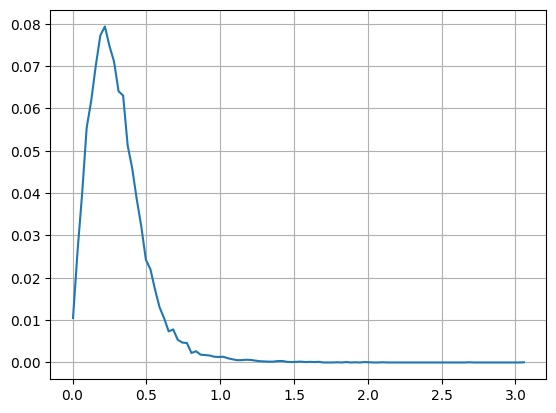

In [23]:
# test nakagami channel function

num_samples =20_000

samples = nakagami_channel(m=0.1, omega=1, snr_db=20, num_samples=num_samples)

samples = np.abs(samples)

hist = np.histogram(samples,100)

plt.plot(hist[1][:-1], hist[0]/num_samples)
plt.grid()
plt.show()

In [24]:
print("iq_samples.shape",iq_samples.shape)
print("nakagami_affected_iq_samples.shape",nakagami_affected_iq_samples.shape)

iq_original_seq = iq_samples.numpy().reshape(-1,1)
iq_received_seq = nakagami_affected_iq_samples.numpy().reshape(-1,1)

# np.random.shuffle(iq_original_seq)
# np.random.shuffle(iq_received_seq)

print("iq_original_seq.shape",iq_original_seq.shape)
print("iq_original_seq.dtype",iq_original_seq.dtype)

print("iq_received_seq.shape",iq_received_seq.shape)
print("iq_received_seq.dtype",iq_received_seq.dtype)

print("same channel per 320*7 \n", "100 channel cases")

iq_samples.shape (320000, 2)
nakagami_affected_iq_samples.shape (320000, 2)
iq_original_seq.shape (640000, 1)
iq_original_seq.dtype complex64
iq_received_seq.shape (640000, 1)
iq_received_seq.dtype complex128
same channel per 320*7 
 100 channel cases


In [25]:
# make the dataset




cc_list = []
for i in range(n_train//block_size):
    cc = r3_get_channel_coeff(  iq_original_seq[i*320*7:(i+1)*320*7],
                       iq_received_seq[i*320*7:(i+1)*320*7]  )
    cc_list.append(cc.item())



plt.stem(np.abs(np.array(cc_list)))
plt.show()

NameError: name 'r3_get_channel_coeff' is not defined

In [26]:
# reshape (frame,sequence,channel uses)
iq_original_seq__rFSC = iq_original_seq.reshape(n_blocks,block_size,-1)
iq_received_seq__rFSC = iq_received_seq.reshape(n_blocks,block_size,-1)
print("iq_original_seq__rFSC.shape: ",iq_original_seq__rFSC.shape)
print("iq_received_seq__rFSC.shape: ",iq_received_seq__rFSC.shape)
print("iq_original_seq__rFSC.dtype: ",iq_original_seq__rFSC.dtype)
print("iq_received_seq__rFSC.dtype: ",iq_received_seq__rFSC.dtype)
print("---------------------------")


conditional_data = iq_received_seq__rFSC[:,:M,:].reshape(n_blocks,-1)
GAN_input = iq_original_seq__rFSC[:,M:,:].reshape(n_blocks,-1)
GAN_real  = iq_received_seq__rFSC[:,M:,:].reshape(n_blocks,-1)
print("conditional_data.shape: ",conditional_data.shape)
print("GAN_input.shape: ",GAN_input.shape)
print("GAN_real.shape: ",GAN_real.shape)
print("conditional_data.dtype: ",conditional_data.dtype)
print("GAN_input.dtype: ",GAN_input.dtype)
print("GAN_real.dtype: ",GAN_real.dtype)




'''
        _________________________________________________________________________
       |                                                                         |
       |                                                                         |
conditional_data ----> |------------|                                            |
                       |  GENERATOR |  ---> predicted_chanel_out vs. GAN_real  ----> [DISCRIMINATOR]  ----> [LOSS]
     GAN_input   ----> |------------|
''';



iq_original_seq__rFSC.shape:  (1000, 320, 2)
iq_received_seq__rFSC.shape:  (1000, 320, 2)
iq_original_seq__rFSC.dtype:  complex64
iq_received_seq__rFSC.dtype:  complex128
---------------------------
conditional_data.shape:  (1000, 8)
GAN_input.shape:  (1000, 632)
GAN_real.shape:  (1000, 632)
conditional_data.dtype:  complex128
GAN_input.dtype:  complex64
GAN_real.dtype:  complex128


In [27]:
# instances to train
i_conditional_inputs = [] # stores [real,imag] x (channel use) for 2**k pilot messages  as features
i_GAN_input = [] # stores [real,imag] x (channel use) : single random message
i_GAN_real = []  # stores [real,imag] x (channel use) : single random message -- after thry channel


def complex_to_parts(c):
    return np.array([np.real(c),np.imag(c)]).reshape(-1,order="F")

for i in range(len(conditional_data)):
    this_cond_pilots_complex = conditional_data[i]
    this_cond_pilots_separated = complex_to_parts(this_cond_pilots_complex)
    #print(this_cond_pilots_separated.shape)


    for j in range(GAN_input.shape[1]):
        this_GAN_input_complex = GAN_input[i,j]
        this_GAN_real_complex  = GAN_real[i,j]
        this_GAN_input_separated = complex_to_parts(this_GAN_input_complex)
        this_GAN_real_separated = complex_to_parts(this_GAN_real_complex)

        i_conditional_inputs.append(this_cond_pilots_separated)
        i_GAN_input.append(this_GAN_input_separated)
        i_GAN_real.append(this_GAN_real_separated)



i_conditional_inputs = np.array(i_conditional_inputs)
i_GAN_input = np.array(i_GAN_input)
i_GAN_real = np.array(i_GAN_real)


In [28]:
print("i_conditional_inputs.shape: ",i_conditional_inputs.shape)
print("i_GAN_input.shape: ", i_GAN_input.shape)

print("i_GAN_real.shape: ", i_GAN_real.shape)



i_conditional_inputs.shape:  (632000, 16)
i_GAN_input.shape:  (632000, 2)
i_GAN_real.shape:  (632000, 2)


In [ ]:
# # test
# complex_to_parts(np.array([1+3j,4+8j]))
# complex_to_parts([54+3j,-3+5j])

In [29]:
dataset = [i_conditional_inputs,i_GAN_input,i_GAN_real]

In [ ]:
# # check unpackability

# a33,b33,c33 = dataset

In [30]:
# now data set is ready

In [33]:
import numpy as np
import tensorflow as tf

#To datasets -> import tensorflow_datasets as tfds

# For models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, \
                                    Dropout, Embedding, Input, Concatenate #, Conv2DTranspose




# For streamlining ML workflow
# import wandb
# from wandb.keras import WandbCallback

# For model memory
# from tensorflow.keras import backend as k
# import humanize

# For visualisation
from matplotlib import pyplot as plt

In [ ]:
# n = 1
# k = 2

# Input_Shape = (2*n,1)   #(n*2,1)   # Shape of the conditional input (this is normalized)
# noise_std = 1           # Standerd deviation for the noise to be added to the conditional values for better generalization (change this)

"""---- Import dataset here ----"""

"""--------"""

# latent_vector_dim = 100 # For the Generator input


#n_batches = len(data//batch_size)



# # Name of the project for Weights and Biases platform
# WB_project = "CGAN"

# # Entity (login) for Weights and Biases platform
# WB_entity = "matusstas" # shearch this


In [34]:
block_size

320

In [35]:
def build_generator():
    noise = Input(shape=(16,))
    input_pilot = Input(shape=(2  **k  *NUM_CHANNEL_USES  *2,))
    input_x = Input(shape=(2,)) # real and imag parts of any symbol
    concat = Concatenate()([noise,input_x,input_pilot])

    l = Dense(128)(concat)
    l = LeakyReLU(alpha = 0.2)(l)
    l = Dense(128)(l)
    l = LeakyReLU(alpha = 0.2)(l)
    l = Dense(128)(l)
    l = LeakyReLU(alpha = 0.2)(l)
    output = Dense(2,activation = 'linear')(l) # real and imag parts of any symbol

    model = Model([noise,input_pilot,input_x],output)
    return model


generator = build_generator()

generator.summary()
# tf.keras.utils.plot_model(generator, show_shapes=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 34)                   0         ['input_2[0][0]',             
                                                                     'input_4[0][0]',       

In [36]:
def build_discriminator():
    input_pilot = Input(  shape= (2  **k  *NUM_CHANNEL_USES  *2,) )
    input_x = Input(shape=(2,))
    concat = Concatenate()([input_pilot,input_x])

    l = Dense(32)(concat)
    l = LeakyReLU(alpha = 0.2)(l)
    l = Dense(32)(l)
    l = LeakyReLU(alpha = 0.2)(l)
    l = Dense(32)(l)
    l = LeakyReLU(alpha = 0.2)(l)
    output = Dense(1,activation = 'sigmoid')(l)

    model = Model([input_pilot,input_x],output)
    return model

discriminator = build_discriminator()

discriminator.summary()
# tf.keras.utils.plot_model(discriminator, show_shapes=True)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 concatenate_1 (Concatenate  (None, 18)                   0         ['input_5[0][0]',             
 )                                                                   'input_6[0][0]']             
                                                                                                  
 dense_12 (Dense)            (None, 32)                   608       ['concatenate_1[0][0]'] 

In [37]:
# https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit#:~:text=When%20you%20need%20to%20customize,running%20your%20own%20learning%20algorithm.

class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, opt_g, opt_d, loss_g, loss_d, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.opt_g = opt_g
        self.opt_d = opt_d
        self.loss_g = loss_g
        self.loss_d = loss_d

    @tf.function
    def train_step(self, dataset):

        dataset = dataset[0]

        i_conditional_inputs = dataset[0]
        i_GAN_input = dataset[1]
        i_GAN_real = dataset[2]

        # Generate samples
        noise = tf.random.normal((len(i_conditional_inputs),16))
        generated = self.generator((noise,i_conditional_inputs,i_GAN_input),training=False)


        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake symbols to the discriminator model
            yhat_real = self.discriminator([i_conditional_inputs, i_GAN_real], training=True)
            yhat_fake = self.discriminator([i_conditional_inputs, generated], training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes symbols
            # We train the discriminator to identify real and fake. 0 for real and 1 as real.
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs (crucial step)
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss
            total_loss_d = self.loss_d(y_realfake, yhat_realfake)

        # Apply backpropagation
        dgrad = d_tape.gradient(total_loss_d, self.discriminator.trainable_variables)
        self.opt_d.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate symbols
            noise2 = tf.random.normal((len(i_conditional_inputs),16))
            generated = self.generator((noise2,i_conditional_inputs,i_GAN_input),training=True)


            # Create the predicted labels
            predicted_labels = self.discriminator([i_conditional_inputs, generated], training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_loss_g = self.loss_g(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backpropagation
        ggrad = g_tape.gradient(total_loss_g, self.generator.trainable_variables)
        self.opt_g.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"loss_d":total_loss_d, "loss_g":total_loss_g}


In [38]:
len(dataset)

3

In [39]:
history_coll = {"loss_d":[],"loss_g":[]}

In [40]:
N_epochs = 100
batch_size = 320
#run = wandb.init(project="CGAN for Wirless autoencoder", entity="matusstas")

# Initialize optimizers# Initialize losses# Initialize models
opt_g = Adam(learning_rate=0.001, beta_1=0.5)
opt_d = Adam(learning_rate=0.0001, beta_1=0.5)

# Initialize losses
loss_g = BinaryCrossentropy()
loss_d = BinaryCrossentropy()

# Initialize models
generator = build_generator()
discriminator = build_discriminator()
gan = GAN(generator, discriminator)
gan.compile(opt_g, opt_d, loss_g, loss_d)


history = gan.fit(dataset, batch_size= batch_size,epochs=N_epochs)

history_coll["loss_d"] +=  (history.history)["loss_d"]
history_coll["loss_g"] +=  (history.history)["loss_g"]


Epoch 1/100
1975/1975 [==============================] - 10s 4ms/step - loss_d: 0.7031 - loss_g: 0.6844
Epoch 2/100
1975/1975 [==============================] - 8s 4ms/step - loss_d: 0.6951 - loss_g: 0.6906
Epoch 3/100
1975/1975 [==============================] - 7s 4ms/step - loss_d: 0.6934 - loss_g: 0.6931
Epoch 4/100
1975/1975 [==============================] - 8s 4ms/step - loss_d: 0.6932 - loss_g: 0.6933
Epoch 5/100
1975/1975 [==============================] - 8s 4ms/step - loss_d: 0.6932 - loss_g: 0.6934
Epoch 6/100
1975/1975 [==============================] - 7s 4ms/step - loss_d: 0.6932 - loss_g: 0.6936
Epoch 7/100
1975/1975 [==============================] - 8s 4ms/step - loss_d: 0.6932 - loss_g: 0.6937
Epoch 8/100
1975/1975 [==============================] - 8s 4ms/step - loss_d: 0.6932 - loss_g: 0.6935
Epoch 9/100
1975/1975 [==============================] - 7s 4ms/step - loss_d: 0.6932 - loss_g: 0.6933
Epoch 10/100
1975/1975 [==============================] - 9s 5ms/step - 

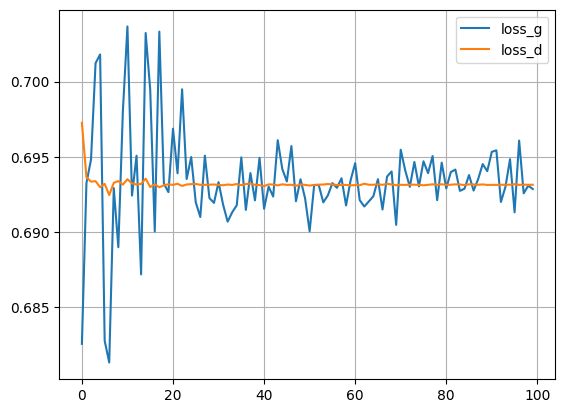

In [41]:
ifg,ax = plt.subplots(1)
ax.plot(history_coll["loss_g"],label="loss_g")
ax.plot(history_coll["loss_d"],label="loss_d")

plt.grid()
plt.legend()
plt.show()

In [42]:
# original dataset we make
len(dataset)


3

In [43]:
i_conditional_inputs.shape,i_GAN_input.shape,i_GAN_real.shape

((632000, 16), (632000, 2), (632000, 2))

In [45]:
# test the generator
# Generate samples
# i_conditional_inputs,i_GAN_input,i_GAN_real = dataset

noise = tf.random.normal((len(i_conditional_inputs),16))
generated = generator((noise,i_conditional_inputs,i_GAN_input),training=False)


print(tf.reduce_mean((i_GAN_real)),tf.reduce_mean((i_GAN_real)**2))

print(tf.reduce_mean((generated)),tf.reduce_mean((generated)**2))

print(tf.reduce_mean((i_GAN_real-generated)),tf.reduce_mean((i_GAN_real-generated)**2))

tf.Tensor(0.0001802017490946416, shape=(), dtype=float64) tf.Tensor(1.9966793218498837, shape=(), dtype=float64)
tf.Tensor(-0.44294575, shape=(), dtype=float32) tf.Tensor(0.9428554, shape=(), dtype=float32)
tf.Tensor(0.44312593, shape=(), dtype=float32) tf.Tensor(2.9382074, shape=(), dtype=float32)
